In [1]:
%matplotlib inline
import sys, os, time
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import math

import cv2
import scipy.signal
from skimage.transform import rotate

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import fiona
import shapely.geometry
import rasterio
import rasterio.features

import torch
import torch.nn

In [2]:
with rasterio.open("../test_inference_50.tif") as f:
    data = f.read().squeeze()
    data_transform = f.transform
    data_crs = f.crs
print(np.unique(data))
data -= 1
print(np.unique(data))
data.shape

[0 1]
[  0 255]


(7586, 6110)

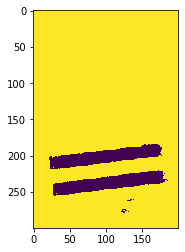

In [3]:
plt.imshow(data[5000:5300, 5200:5400])

In [4]:
import shapely.geometry
import rasterio
import rasterio.features
import geopandas as gpd

In [5]:
def extract_polygons(input_fn):
    data = None
    with rasterio.open(input_fn) as f:
        data = f.read().squeeze()
        data_transform = f.transform
        data_crs = f.crs
    mask = data == 1
    polygons = list(
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) in enumerate(rasterio.features.shapes(data, mask=mask, transform=data_transform))
    )
    return polygons

In [6]:
def post_processing(input_fn, area_thresh, aspect_ratio_thresh):
    def get_side_lengths(shape):
        def distance(pt1, pt2):
            return math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        xs, ys = shape.boundary.xy
        pts = list(zip(xs, ys))
        lengths = []
        for i in range(len(pts)-1):
            lengths.append(distance(pts[i], pts[i+1]))
        assert len(lengths) == 4
        return sorted(lengths)

    polygons = extract_polygons(input_fn)
    print(len(polygons))
    
#     Filter by shape
    shape_area_threshold = area_thresh

    polygons_filtered_by_size = []
    for polygon in polygons:
        shape = shapely.geometry.shape(polygon["geometry"])

        if shape.area > shape_area_threshold:
            polygons_filtered_by_size.append(polygon)
    
    print(len(polygons_filtered_by_size))
            
    # Filter by aspect ratio
    aspect_ratio_threshold = aspect_ratio_thresh

    polygons_filtered_by_aspect_ratio = []
    poly_list = []
    for polygon in polygons_filtered_by_size:
        shape = shapely.geometry.shape(polygon["geometry"])


        side_lengths = get_side_lengths(shape.minimum_rotated_rectangle)    
        short_length = min(side_lengths)
        long_length = max(side_lengths)

        aspect_ratio = long_length / short_length
        if aspect_ratio > aspect_ratio_threshold:
            polygons_filtered_by_aspect_ratio.append(polygon)
            poly_list.append(shape)

    print(len(polygons_filtered_by_aspect_ratio))
            
    polys_gdf = gpd.GeoDataFrame(geometry=poly_list)
    list_of_polygons = []
    polygons_filtered_by_aspect_ratio_and_size = []

    for i in range(len(polys_gdf)):
        plt.close('all')
        fig, ax = plt.subplots()
        ax.axis('off')
        polys_gdf.loc[[i],'geometry'].plot(ax = ax)
        fig.canvas.draw()
        arr = np.array(fig.canvas.renderer.buffer_rgba())[:,:,0]
        arr[arr == 255] = 0
        arr[arr == 31] = 1
        list_of_polygons.append(arr)
        polygons_filtered_by_aspect_ratio_and_size.append(polygons_filtered_by_aspect_ratio[i])
    
    return list_of_polygons, polygons_filtered_by_aspect_ratio_and_size, data_crs

1432
132
127


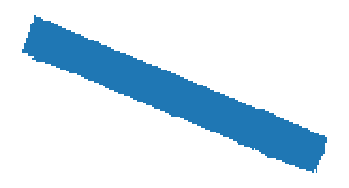

In [7]:
# lop,polygons_filtered_by_aspect_ratio_and_size,crs = post_processing("../test_inference_50.tif", 525, 4)
lop, polygons_filtered_by_aspect_ratio_and_size, crs = post_processing("../test_inference_50.tif", 525, 4)

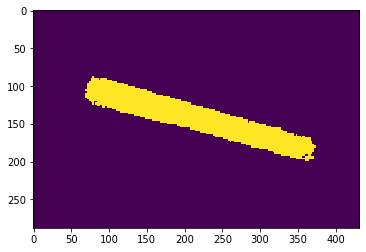

In [8]:
plt.imshow(lop[7])

In [9]:
test = lop[0]
test[np.newaxis, np.newaxis, :, :].shape

(1, 1, 288, 432)

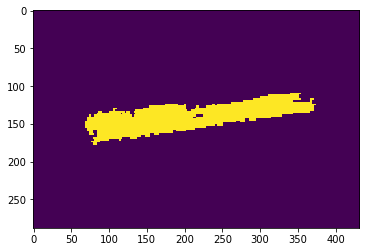

In [10]:
plt.imshow(test)

# Method 1

In [11]:
def generate_rectangle(aspect_ratio, height, width, rotation, min_pixel=100):
    redo = True
    img = np.zeros((width, height), dtype=np.uint8)
    while redo == True:
        start_x = np.random.randint(width//2)
        start_y = np.random.randint(height//2)

        # Chooses from short side...
        short_side = np.random.randint(height//3)
        long_side  = short_side * aspect_ratio

        end_y = int(start_y + short_side)
        end_x = int(start_x + long_side)

        # Get center
        center_x = (max(start_x,end_x) - min(start_x, end_x)) / 2
        center_y = (max(start_y,end_y) - min(start_y, end_y)) / 2

        rec = cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (10,10,10), -1)
        img = rotate(image=img, angle=rotation)

        area = short_side * long_side
        percent_area = area / (height*width) 
        
        # Make sure there's no empty images (at least 100 pixels are in img)
        if np.count_nonzero(img) < (min_pixel) or percent_area < 0.1:
            # reset
            redo = True
            img = np.zeros((width, height), dtype=np.uint8)
        else:
            redo = False
                    
    return img / img.sum()

aspect_ratio = lambda: np.random.normal(loc=9.07, scale=1.71)

pos_kernels = []
for i in range(36):
    rect = generate_rectangle(aspect_ratio(), 432, 288, np.random.randint(360), 800)
    pos_kernels.append(rect)
    
neg_kernels = []
for pos_kernel in pos_kernels:
    neg_kernel = 1 - pos_kernel.copy()
    neg_kernel = neg_kernel / (neg_kernel.sum() + 0.00001)
    neg_kernels.append(neg_kernel)

In [12]:
# Set up lop for torch
torch_lop = []
for p in lop:
    data_torch = torch.from_numpy(p[np.newaxis, np.newaxis, :, :].astype(np.float16)).to("cuda")
    data_torch.require_grad = False
    torch_lop.append(data_torch)

pos_kernels = np.array(pos_kernels)
pos_kernels = pos_kernels[:,np.newaxis,:,:]
pos_kernels = torch.from_numpy(pos_kernels.astype(np.float16)).to("cuda")
pos_kernels.require_grad = False

neg_kernels = np.array(neg_kernels)
neg_kernels = neg_kernels[:,np.newaxis,:,:]
neg_kernels = torch.from_numpy(neg_kernels.astype(np.float16)).to("cuda")
neg_kernels.require_grad = False

In [31]:
filter_corrs_idx = []
count = 0
lop_final = []

# Next step would be to filter by max activation, but rn this will suffice i hope

for i in range(len(torch_lop)):
    outputs_pos = torch.nn.functional.conv2d(torch_lop[i], pos_kernels, padding=25)

    with torch.no_grad():
        outputs_pos = outputs_pos.cpu().numpy().astype(np.float32)
    outputs_pos = np.rollaxis(outputs_pos.squeeze(), 0, 3)
    torch.cuda.empty_cache()

    outputs_neg = torch.nn.functional.conv2d(1-data_torch, neg_kernels, padding=25)

    with torch.no_grad():
        outputs_neg = outputs_neg.cpu().numpy().astype(np.float32)
    outputs_neg = np.rollaxis(outputs_neg.squeeze(), 0, 3)
    torch.cuda.empty_cache()

    if (outputs_pos.max()) > 0.3:
        filter_corrs_idx.append(i)

for i in range(len(lop)):
    if (i in filter_corrs_idx):
        lop_final.append(polygons_filtered_by_aspect_ratio_and_size[i])

with fiona.open(
    'test_m1.geojson', 'w',
    driver="GeoJSON",
    crs= crs,
    schema={'properties': [('raster_val', 'int')], 'geometry': 'Polygon'}
) as dst:
    dst.writerecords(lop_final)

# Method 2

In [47]:
def get_gt_training():
    pol = []
    polygons = extract_polygons('../binary_raster_md_tif/m_3807537_nw_18_1_20170611_inference_rasterized.tif')  
    for polygon in polygons:
        shape = shapely.geometry.shape(polygon["geometry"])
        pol.append(polygon)
    return pol

In [ ]:
# Ground truth as training set
train_pol = get_gt_training()

# Set up lop for torch
torch_train_lop = []
for p in train_pol:
    data_torch = torch.from_numpy(p[np.newaxis, np.newaxis, :, :].astype(np.float16)).to("cuda")
    data_torch.require_grad = False
    torch_lop.append(data_torch)